In [ ]:
import cv2
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
import time
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

Configurations

In [9]:
IMG_SIZE = (64, 64)
SAMPLES_PER_PERSON = 20
CLASS_NAMES = ["Male", "Female"]

Visualizations

In [3]:
def plot_feature_importance(model, img_size, class_names):
    """
    Plots a single heatmap showing the weights of the Linear SVM.
    Positive weights (e.g., Red) provide evidence for the second class (e.g., Female).
    Negative weights (e.g., Blue) provide evidence for the first class (e.g., Male).
    """
    if not hasattr(model, 'coef_') or model.kernel != 'linear':
        print("Error: Model must be a Linear SVM with 'coef_' attribute.")
        return
        
    print("\n" + "="*60)
    print("VISUALIZING SINGLE FEATURE IMPORTANCE MAP")
    print("="*60)

    
    weights = model.coef_[0]
    weight_map = weights.reshape(img_size)
    
    # --- Plotting ---
    plt.figure(figsize=(10, 8))
    
    # Use a diverging color map (like 'coolwarm')
    sns.heatmap(weight_map, cmap='coolwarm', cbar=True, square=True,
                cbar_kws={'label': f'Weight Magnitude: Evidence for {class_names[1]} (Positive) vs. {class_names[0]} (Negative)'})
    
    plt.title('SVM Feature Importance: Single Diverging Map', fontweight='bold', fontsize=14)
    plt.ylabel('Image Row', fontsize=12)
    plt.xlabel('Image Column', fontsize=12)
    plt.tight_layout()
    plt.savefig('svm_feature_importance_single.png', dpi=300, bbox_inches='tight')
    print("✓ Single feature importance map saved as 'svm_feature_importance_single.png'")
    plt.show()

In [4]:
def plot_confusion_matrix(y_test, y_pred, class_names):
    """Plots the confusion matrix."""
    print("\n" + "="*60)
    print("PLOTTING CONFUSION MATRIX")
    print("="*60)
    
    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix', fontweight='bold', fontsize=14)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300)
    print("✓ Confusion Matrix saved as 'confusion_matrix.png'")
    plt.show()

In [11]:
def collect_gender_data():
    """Collect training images from multiple people"""
    
    # Load face detection model
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    cap = cv2.VideoCapture(0) 
    
    if not cap.isOpened():
        print("ERROR: Could not open webcam! Please check camera connection or try changing 'cv2.VideoCapture(0)' to 'cv2.VideoCapture(1)'.")
        cv2.destroyAllWindows() 
        return None, None
    
    X_data = []
    y_data = []
    person_names = []
    
    window_name = 'Gender Classification - Data Collection - PRESS Q TO QUIT'
    cv2.namedWindow(window_name)

    for class_idx, class_name in enumerate(CLASS_NAMES):
        print(f"\n{'='*60}")
        print(f"COLLECTING: {class_name.upper()} DATA")
        print(f"{'='*60}")
        
        person_num = 1
        
        while True:
            print(f"\n--- {class_name} Person #{person_num} ---")
            person_name = input(f"Enter person's name (or 'done' to finish {class_name}s): ").strip()
            
            if person_name.lower() == 'done':
                if person_num == 1:
                    print("  You need at least 1 person! Try again.")
                    continue       
                break
            
            if not person_name:
                person_name = f"{class_name}_{person_num}"
            
            print(f"\nGET READY: Look at the webcam window that opened.")
            print(f"To START collection for {person_name}, press the [SPACE] bar when the webcam window is ACTIVE.")
            print("To QUIT collection entirely, press [q].")
            
            collected = 0
            collecting = False
            
            while collected < SAMPLES_PER_PERSON:
                ret, frame = cap.read()
                if not ret:
                    print("Failed to grab frame. Exiting collection.")
                    break
                
                frame = cv2.flip(frame, 1)
                gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                faces = face_cascade.detectMultiScale(gray, 1.3, 5)
                
                for (x, y, w, h) in faces:
                    cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

                status_color = (0, 255, 255)
                if collecting:
                    status_text = f"COLLECTING: {collected}/{SAMPLES_PER_PERSON}"
                    status_color = (0, 0, 255)
                else:
                    status_text = "Ready - Press SPACE to START"
                    status_color = (255, 255, 0)
                
                cv2.putText(frame, status_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, status_color, 2)
                cv2.putText(frame, f"Person: {person_name}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
                cv2.putText(frame, "Press 'q' in the window to EXIT", (10, frame.shape[0] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (100, 100, 255), 1)

                cv2.imshow(window_name, frame)
                
                key = cv2.waitKey(1) & 0xFF
                
                if key == ord(' '):
                    if not collecting:
                        collecting = True
                        print(f"  --> STARTED collecting from {person_name}...")
                elif key == ord('q'):
                    print("Collection manually quit by user.")
                    cap.release()
                    cv2.destroyAllWindows()
                    return None, None
                
                if collecting and len(faces) > 0:
                    (x, y, w, h) = faces[0]
                    face_gray = gray[y:y+h, x:x+w]
                    resized = cv2.resize(face_gray, IMG_SIZE)
                    flattened = resized.flatten()
                    
                    X_data.append(flattened)
                    y_data.append(class_idx)
                    person_names.append(f"{class_name}_{person_name}")
                    collected += 1
                    
                    time.sleep(0.05)
                
                if collected == SAMPLES_PER_PERSON:
                    print(f"   Collected {collected} samples from {person_name}!")
                    break

            if not ret or collected < SAMPLES_PER_PERSON:
                if not ret: print("Error occurred during frame grab.")
                break 

            person_num += 1
            
            if person_num > 1 and collected > 0:
                more = input(f"\n  Add another {class_name.lower()} person? (y/n): ").lower()
                if more != 'y':
                    break
        
        print(f"\n✓ Finished collecting all {class_name} data!")

    cap.release()
    cv2.destroyAllWindows()
    
    print(f"\n{'='*60}")
    print("DATA COLLECTION SUMMARY")
    print(f"{'='*60}")
    unique_people = set(person_names)
    print(f"Total samples: {len(X_data)}")
    print(f"Unique people: {len(unique_people)}")
    
    return np.array(X_data), np.array(y_data)

Training the classification model

In [12]:
def train_gender_classifier(X, y):
    """Train Linear SVM for gender classification and generate visualizations."""
    print("\n" + "="*60)
    print("TRAINING GENDER CLASSIFIER")
    print("="*60)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"\nTraining set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    
    # Standardize features
    print("\nStandardizing features...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train Linear SVM
    print("Training Linear SVM...")
    model = SVC(kernel='linear', C=1.0, probability=True, random_state=42)
    model.fit(X_train_scaled, y_train)
    
    # Evaluate on test set
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"\n{'='*60}")
    print("MODEL PERFORMANCE")
    print(f"{'='*60}")
    print(f"Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=CLASS_NAMES))
    
    # Cross-validation
    print("Performing 5-fold cross-validation...")
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    print(f"Mean CV accuracy: {cv_scores.mean():.4f} (Std Dev: {cv_scores.std():.4f})")
    
    # --- VISUALIZATIONS ---
    if hasattr(model, 'coef_') and model.kernel == 'linear':
        plot_feature_importance(model, IMG_SIZE, CLASS_NAMES) 
        plot_confusion_matrix(y_test, y_pred, CLASS_NAMES)
    
    print("\nClassifier training and visualization complete.")
    
    # Save the model
    print("\nSaving trained model and scaler...")
    with open('gender_classifier.pkl', 'wb') as f:
        pickle.dump((model, scaler, CLASS_NAMES, accuracy), f)
    print("✓ Model saved successfully as 'gender_classifier.pkl'")
    
    return model, scaler, accuracy

In [13]:
def real_time_gender_prediction(model, scaler):
    """Run real-time gender classification"""
    
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    cap = cv2.VideoCapture(0)
    
    if not cap.isOpened():
        print("ERROR: Could not open webcam for prediction!")
        return
        
    print(f"\n{'='*60}")
    print("REAL-TIME GENDER CLASSIFICATION")
    print(f"{'='*60}")
    print("Press 'q' to quit")
    
    while True:
        ret, frame = cap.read()
        if not ret: break
        
        frame = cv2.flip(frame, 1)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        
        for (x, y, w, h) in faces:
            # Prepare face for model
            face_gray = gray[y:y+h, x:x+w]
            resized = cv2.resize(face_gray, IMG_SIZE)
            flattened = resized.flatten().reshape(1, -1)
            scaled = scaler.transform(flattened)
            
            # Predict
            prediction = model.predict(scaled)[0]
            confidence = model.predict_proba(scaled)[0, prediction] * 100
            
            # Draw results
            label = f"{CLASS_NAMES[prediction]}: {confidence:.1f}%"
            color = (255, 0, 0) if prediction == 0 else (0, 0, 255) # Blue for Male (0), Red for Female (1) - Change colors if necessary
            cv2.rectangle(frame, (x, y), (x+w, y+h), color, 3)
            cv2.putText(frame, label, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)
            
        cv2.imshow('Gender Classification - Real-Time', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'): break
        
    cap.release()
    cv2.destroyAllWindows()
    print(f"\n{'='*60}")
    print("GENDER CLASSIFICATION COMPLETE!")
    print(f"{'='*60}")


def main():
    print("\n Starting Gender Classification System")
    time.sleep(0.5)
    
    print("\n" + "="*60)
    print("STEP 1: DATA COLLECTION")
    print("="*60)
    
    X_data, y_data = collect_gender_data() 
    
    if X_data is None or len(X_data) < 20:
        print("\nData collection cancelled or too few samples. Training skipped.")
        return
    
    model, scaler, accuracy = train_gender_classifier(X_data, y_data)
    
    if accuracy > 0.6:
        start_prediction = input("\nStart real-time prediction? (y/n): ").lower()
        if start_prediction == 'y':
            real_time_gender_prediction(model, scaler)

def load_and_predict():
    """Load a saved model and run predictions"""
    try:
        with open('gender_classifier.pkl', 'rb') as f:
            model, scaler, class_names_loaded, accuracy = pickle.load(f)
        
        # Ensure the global CLASS_NAMES matches
        global CLASS_NAMES
        CLASS_NAMES = class_names_loaded
        
        print(f"\nModel loaded successfully! Accuracy: {accuracy*100:.1f}%")
        real_time_gender_prediction(model, scaler)
    except FileNotFoundError:
        print("\nNo saved model found ('gender_classifier.pkl').")
        print("Please train a new model first by selecting option 1.")

Testing the model


GENDER CLASSIFICATION WITH LINEAR SVM

Options:
1. Train new model (collect data from multiple people)
2. Load saved model (skip training)

 Starting Gender Classification System

STEP 1: DATA COLLECTION

COLLECTING: MALE DATA

--- Male Person #1 ---

GET READY: Look at the webcam window that opened.
To START collection for m1, press the [SPACE] bar when the webcam window is ACTIVE.
To QUIT collection entirely, press [q].
  --> STARTED collecting from m1...
   Collected 20 samples from m1!

✓ Finished collecting all Male data!

COLLECTING: FEMALE DATA

--- Female Person #1 ---

GET READY: Look at the webcam window that opened.
To START collection for f1, press the [SPACE] bar when the webcam window is ACTIVE.
To QUIT collection entirely, press [q].
  --> STARTED collecting from f1...
   Collected 20 samples from f1!

✓ Finished collecting all Female data!

DATA COLLECTION SUMMARY
Total samples: 40
Unique people: 2

TRAINING GENDER CLASSIFIER

Training set: 32 samples
Test set: 8 sampl

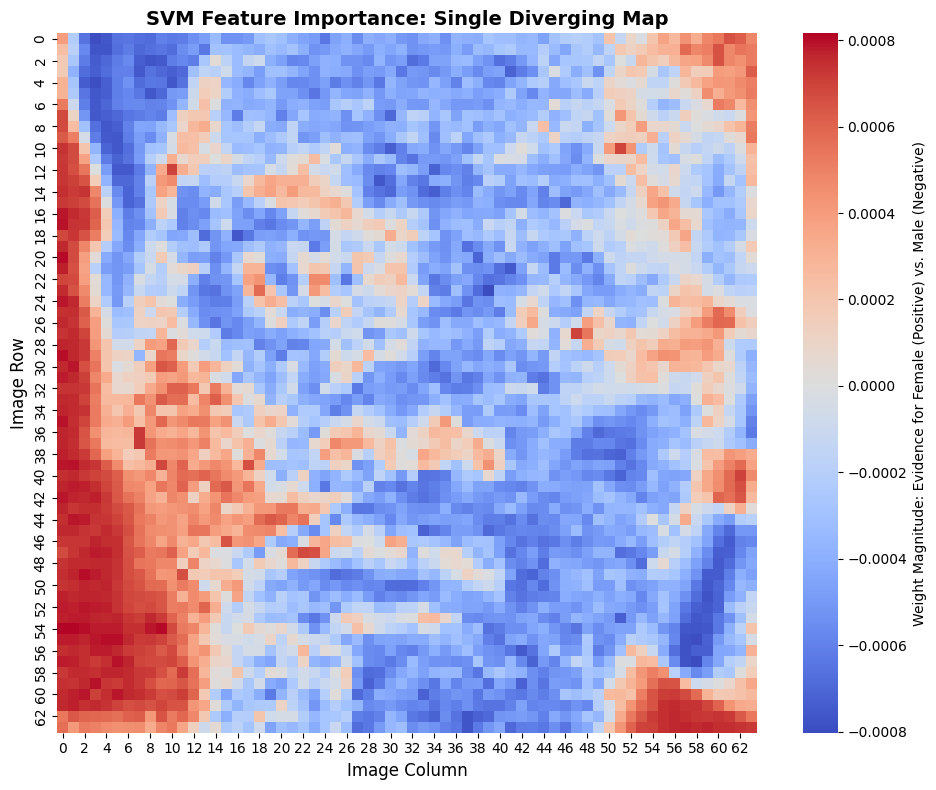


PLOTTING CONFUSION MATRIX
✓ Confusion Matrix saved as 'confusion_matrix.png'


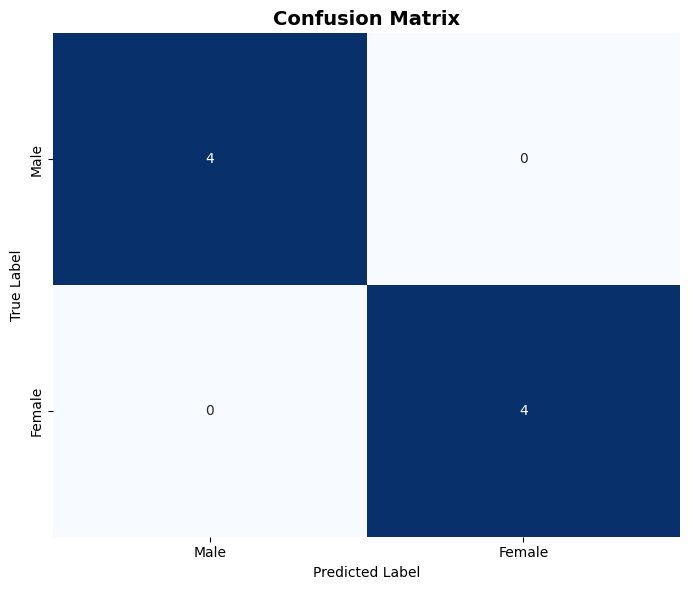


Classifier training and visualization complete.

Saving trained model and scaler...
✓ Model saved successfully as 'gender_classifier.pkl'

REAL-TIME GENDER CLASSIFICATION
Press 'q' to quit

GENDER CLASSIFICATION COMPLETE!


In [14]:
if __name__ == "__main__":
    print("\n" + "="*60)
    print("GENDER CLASSIFICATION WITH LINEAR SVM")
    print("="*60)
    print("\nOptions:")
    print("1. Train new model (collect data from multiple people)")
    print("2. Load saved model (skip training)")
    
    choice = input("\nEnter choice (1 or 2): ").strip()
    
    if choice == '2':
        load_and_predict()
    else:
        main()